# Code to plot SI1

In [59]:
## imports (generic)
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'regular' # to use latex math symbols like mu

# generate setting for file paths

In [60]:
## input data from peat_exp_analysis/v25
path_data = '../data/'
## set path for storing the figure made by this file
path_fig = '../fig/'

In [61]:
# import the data
ds_calc = xr.open_dataset(path_data + 'ds_SI1.nc')
ds_calc

<xarray.Dataset>
Dimensions:           (scen: 288, mod_Epeat: 5, percentile: 7, var_name_cum: 4,
                       target_T: 4)
Coordinates:
  * mod_Epeat         (mod_Epeat) object 'LPJ' 'LPX' ... 'LPJ-GUESS_multiLayer'
  * scen              (scen) object 'SSP2-45_ConstUntil2030_nz2040_ov-10000_m...
  * percentile        (percentile) float64 0.15 99.85 2.5 97.5 16.0 84.0 50.0
  * var_name_cum      (var_name_cum) object 'cum_D_Ept_CO2' ... 'cum_abs_Ept_...
  * target_T          (target_T) float64 1.5 2.0 2.5 3.0
Data variables:
    Tpeak_bg          (scen, mod_Epeat) float32 ...
    Tpeak_per         (scen, percentile, mod_Epeat) float32 ...
    best_guess_cum    (scen, var_name_cum, mod_Epeat) float32 ...
    per_weighted_cum  (scen, var_name_cum, percentile, mod_Epeat) float32 ...
    ov_msk_bg         (scen, target_T, mod_Epeat) float32 ...
    ov_msk_per        (scen, percentile, target_T, mod_Epeat) float32 ...
    cumT_bg           (scen, target_T, mod_Epeat) float32 ...
    cumT_per          (scen, percentile, target_T, mod_Epeat) float32 ...
Attributes:
    source file:  OUT_cut_scen_tier2_peat.nc from expv7.40

# Plotting

##  define function to plot

In [62]:
def figSI1_plt(ds, var_C, var_T, scen, lab):
    # the function to make a plot between cumulative CH4/CO2 and Tpeak/cum_T
    # var_C can be 'cum_abs_Ept_CO2' or 'cum_abs_Ept_CH4'
    # var_T can be 'peakT' or 'cumT'
    # scen can be 'SSP', or 'PROVIDE'
    # lab can be 'shp', 'colr','none'
    col_mod = {'LPJ':'#00429d','LPX': '#a5d5d8', 'ORCHIDEE':'#ff9857', 'LPJ-GUESS':'#ffbcaf', 'LPJ-GUESS_multiLayer':'#cf3759'}
    shp_mod = {'LPJ':'o','LPX': 's', 'ORCHIDEE':'^', 'LPJ-GUESS':'*', 'LPJ-GUESS_multiLayer':'d'}
    for targetT in tgt_lst:
        for mod in ds.mod_Epeat.values:
            ds_target = ds.sel(mod_Epeat = mod).where(ds.ov_msk_bg.sel(target_T=targetT, mod_Epeat = mod))
            if var_T == 'peakT':
                if var_C != 'deltaC':
                    # mean values for x and y
                    x = ds_target.Tpeak_bg
                    x[x > 5000] = np.nan
                    y = ds_target.best_guess_cum.sel(var_name_cum = var_C).drop('var_name_cum')
                    #percentile values for x and y
                    for per in [16]:
                        ds_per = ds_target
                        x_lower_error = x - ds_per.Tpeak_per.sel(percentile = per)
                        x_upper_error = ds_per.Tpeak_per.sel(percentile = 100-per) - x

                        y_lower_error = y - ds_per.per_weighted_cum.sel(var_name_cum = var_C).drop('var_name_cum').sel(percentile = per)
                        y_upper_error = ds_per.per_weighted_cum.sel(var_name_cum = var_C).drop('var_name_cum').sel(percentile = 100-per) - y

                        asymmetric_error_x = [x_lower_error.values, x_upper_error.values]
                        asymmetric_error_y = ([y_lower_error.values, y_upper_error.values]) if 'CO2' in var_C else ([y_lower_error.values/1000, y_upper_error.values/1000])
                        # Replace negative values with zero
                        asymmetric_error_y = ([x if x >= 0 else np.nan for x in asymmetric_error_y[0]], [x if x >= 0 else np.nan for x in asymmetric_error_y[1]])

                        plt.errorbar(x, y if 'CO2' in var_C else y/1000, linewidth=1,
                                    xerr = asymmetric_error_x, yerr = asymmetric_error_y, 
                                    fmt='D' if scen =='SSP' else 'o',  markerfacecolor='none' if scen =='PROVIDE' else col_mod[mod], 
                                    color = col_mod[mod], capsize = 0, alpha = 0.3 if scen == 'PROVIDE' else 0.8,
                                    label = '68% confidence interval' if targetT == 1.5 and mod =='LPJ' and lab == 'colr' else '')
                else:
                     # mean values for x and y
                    x = ds_target.Tpeak_bg
                    x[x > 5000] = np.nan
                    y = ds_target.best_guess_cum.sel(var_name_cum = 'cum_abs_Ept_CO2').drop('var_name_cum')+ds_target.best_guess_cum.sel(var_name_cum = 'cum_abs_Ept_CH4').drop('var_name_cum')/1000
                    #percentile values for x and y
                    for per in [16]:
                        ds_per = ds_target
                        x_lower_error = x - ds_per.Tpeak_per.sel(percentile = per)
                        x_upper_error = ds_per.Tpeak_per.sel(percentile = 100-per) - x

                        y_lower_error = y - (ds_per.per_weighted_cum.sel(var_name_cum = 'cum_abs_Ept_CO2').drop('var_name_cum').sel(percentile = per)+ds_per.per_weighted_cum.sel(var_name_cum = 'cum_abs_Ept_CH4').drop('var_name_cum').sel(percentile = per)/1000)
                        y_upper_error = (ds_per.per_weighted_cum.sel(var_name_cum = 'cum_abs_Ept_CO2').drop('var_name_cum').sel(percentile = 100-per)+ds_per.per_weighted_cum.sel(var_name_cum = 'cum_abs_Ept_CH4').drop('var_name_cum').sel(percentile = 100-per)/1000) - y

                        asymmetric_error_x = [x_lower_error.values, x_upper_error.values]
                        asymmetric_error_y = ([y_lower_error.values, y_upper_error.values]) if 'CO2' in var_C else ([y_lower_error.values/1000, y_upper_error.values/1000])

                        # Replace negative values with zero
                        asymmetric_error_y = ([x if x >= 0 else np.nan for x in asymmetric_error_y[0]], [x if x >= 0 else np.nan for x in asymmetric_error_y[1]])

                        plt.errorbar(x, -y, linewidth=1,
                                    xerr = asymmetric_error_x, yerr = asymmetric_error_y, 
                                    fmt='D' if scen =='SSP' else 'o',  markerfacecolor='none' if scen =='PROVIDE' else col_mod[mod], 
                                    color = col_mod[mod], capsize = 0, alpha = 0.3 if scen == 'PROVIDE' else 0.8,
                                    label = '68% confidence interval' if targetT == 1.5 and mod =='LPJ' and lab == 'colr' else '')
            elif var_T == 'cumT':
                if var_C != 'deltaC':
                    # mean values for x and y
                    x = ds_target.cumT_bg.sel(target_T = targetT)
                    x[x > 5000] = np.nan
                    y = ds_target.best_guess_cum.sel(var_name_cum = var_C).drop('var_name_cum')
                    #percentile values for x and y
                    for per in [16]:
                        ds_per = ds_target
                        x_lower_error = x - ds_per.cumT_per.sel(percentile = per, target_T = targetT)
                        x_upper_error = ds_per.cumT_per.sel(percentile = 100-per, target_T = targetT) - x

                        y_lower_error = y - ds_per.per_weighted_cum.sel(var_name_cum = var_C).drop('var_name_cum').sel(percentile = per)
                        y_upper_error = ds_per.per_weighted_cum.sel(var_name_cum = var_C).drop('var_name_cum').sel(percentile = 100-per) - y

                        asymmetric_error_x = [x_lower_error.values, x_upper_error.values]
                        asymmetric_error_y = ([y_lower_error.values, y_upper_error.values]) if 'CO2' in var_C else ([y_lower_error.values/1000, y_upper_error.values/1000])
                        # Replace negative values with zero
                        asymmetric_error_y = ([x if x >= 0 else np.nan for x in asymmetric_error_y[0]], [x if x >= 0 else np.nan for x in asymmetric_error_y[1]])

                        plt.errorbar(x, y if 'CO2' in var_C else y/1000, linewidth=1,
                                    xerr = asymmetric_error_x, yerr = asymmetric_error_y,
                                    fmt='D' if scen =='SSP' else 'o', markerfacecolor='none' if scen =='PROVIDE' else col_mod[mod], 
                                    color = col_mod[mod], capsize = 0, alpha = 0.3 if scen == 'PROVIDE' else 0.8,
                                    label = '68% confidence interval' if targetT == 1.5 and mod =='LPJ' and lab == 'colr' else '')
                else:
                    # mean values for x and y
                    x = ds_target.cumT_bg.sel(target_T = targetT)
                    x[x > 5000] = np.nan
                    y = ds_target.best_guess_cum.sel(var_name_cum = 'cum_abs_Ept_CO2').drop('var_name_cum')+ds_target.best_guess_cum.sel(var_name_cum = 'cum_abs_Ept_CH4').drop('var_name_cum')/1000
                    #percentile values for x and y
                    for per in [16]:
                        ds_per = ds_target
                        x_lower_error = x - ds_per.cumT_per.sel(percentile = per, target_T = targetT)
                        x_upper_error = ds_per.cumT_per.sel(percentile = 100-per, target_T = targetT) - x

                        y_lower_error = y - (ds_per.per_weighted_cum.sel(var_name_cum = 'cum_abs_Ept_CO2').drop('var_name_cum').sel(percentile = per)+ds_per.per_weighted_cum.sel(var_name_cum = 'cum_abs_Ept_CH4').drop('var_name_cum').sel(percentile = per)/1000)
                        y_upper_error = (ds_per.per_weighted_cum.sel(var_name_cum = 'cum_abs_Ept_CO2').drop('var_name_cum').sel(percentile = 100-per)+ds_per.per_weighted_cum.sel(var_name_cum = "cum_abs_Ept_CH4").drop('var_name_cum').sel(percentile = 100-per)/1000) - y

                        asymmetric_error_x = [x_lower_error.values, x_upper_error.values]
                        asymmetric_error_y = ([y_lower_error.values, y_upper_error.values]) if 'CO2' in var_C else ([y_lower_error.values/1000, y_upper_error.values/1000])
                        # Replace negative values with zero
                        asymmetric_error_y = ([x if x >= 0 else np.nan for x in asymmetric_error_y[0]], [x if x >= 0 else np.nan for x in asymmetric_error_y[1]])

                        plt.errorbar(x, -y, linewidth=1,
                                    xerr = asymmetric_error_x, yerr = asymmetric_error_y,
                                    fmt='D' if scen =='SSP' else 'o', markerfacecolor='none' if scen =='PROVIDE' else col_mod[mod], 
                                    color = col_mod[mod], capsize = 0, alpha = 0.3 if scen == 'PROVIDE' else 0.8,
                                    label = '68% confidence interval' if targetT == 1.5 and mod =='LPJ' and lab == 'colr' else '')

            else:
                print('Wrong Temperature Input')
            
            plt.scatter(x, y if 'CO2' in var_C else (y/1000 if 'CH4' in var_C else -y), 
                        facecolors='none' if scen =='PROVIDE' else col_mod[mod], edgecolor = col_mod[mod], 
                        marker ='D' if scen =='SSP' else 'o', alpha = 0.5 if scen =='PROVIDE' else 1, 
                        label = mod if lab == 'colr' and targetT == 1.5 else scen if lab == 'shp' and targetT == 1.5 and mod == 'LPJ' else '')


## color choices

In [63]:
col = ['#00429d', '#4771b2', '#73a2c6', '#a5d5d8', '#ffffe0', '#ffcc88','#ff9857', '#e77b2e', '#ffbcaf', '#f4777f', '#cf3759', '#93003a']
col_targetT = {1.5:'#4771b2',
               2.: '#a5d5d8', 
               2.5: '#ff9857', 
               3.0: '#cf3759'} 

col_txt = 'black'
col_txt_dsk = {1.5:'#00429d', 
               2.: '#73a2c6', 
               2.5: '#e77b2e', 
               3.0: '#93003a'}

## plot 1 - deltaC - Tpeak

The process of filering out data is very long (42min and still did not finish)

In [64]:
## filter out ds_calc with combined_mask
#ds_calc = ds_calc.drop(['D_Tg','D_CO2','D_CH4'])
#ds_calc = ds_calc.where(combined_mask, drop=True)
tgt_lst = [1.5,2,2.5]
col_mod = {'LPJ':'#00429d','LPX': '#a5d5d8', 'ORCHIDEE':'#ff9857', 'LPJ-GUESS':'#ffbcaf', 'LPJ-GUESS_multiLayer':'#cf3759'}

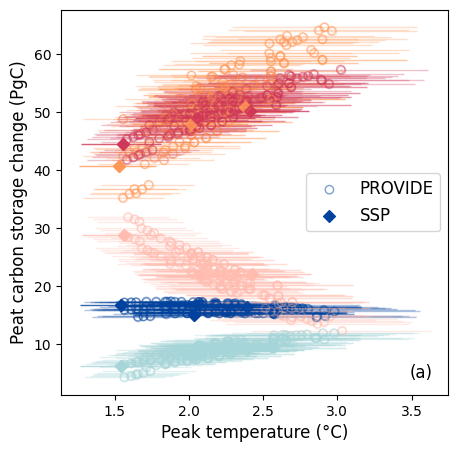

In [65]:
plt.figure(figsize=(5.,5.))
figSI1_plt(ds_calc, 'deltaC','peakT', 'PROVIDE','shp') # plot PROVIDE-tier2
figSI1_plt(ds_calc_ssp, 'deltaC','peakT', 'SSP','shp') # plot ssp
plt.legend(fontsize = 12, loc = 'center right')
plt.text(0.9, 0.08, "(a)", transform=plt.gca().transAxes, fontsize = 12,  va='top')
plt.xlabel('Peak temperature (\u00B0C)', fontsize = 12)
plt.ylabel('Peat carbon storage change (PgC)', fontsize = 12)
plt.savefig(path_fig+'sub_figSI1_Tpeak_deltaC.png', dpi=300, bbox_inches='tight')

## plot 2 - deltaC - cumT

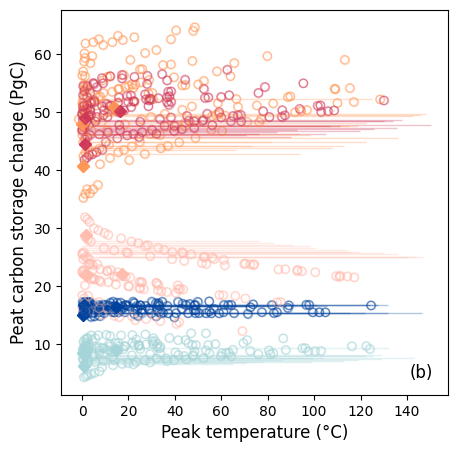

In [66]:
plt.figure(figsize=(5.,5.))
figSI1_plt(ds_calc, 'deltaC','cumT', 'PROVIDE','shp') # plot PROVIDE-tier2
figSI1_plt(ds_calc_ssp, 'deltaC','cumT', 'SSP','shp') # plot ssp
#plt.legend(fontsize = 12)
plt.text(0.9, 0.08, "(b)", transform=plt.gca().transAxes, fontsize = 12,  va='top')
plt.xlabel('Peak temperature (\u00B0C)', fontsize = 12)
plt.ylabel('Peat carbon storage change (PgC)', fontsize = 12)
plt.savefig(path_fig+'sub_figSI1_cumT_deltaC.png', dpi=300, bbox_inches='tight')

## plot 3 - CO2 - Tpeak

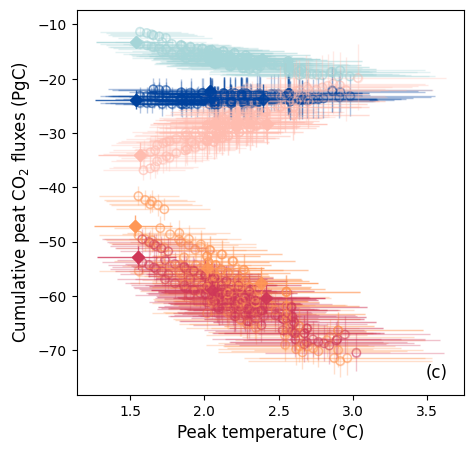

In [67]:
plt.figure(figsize=(5.,5.))
figSI1_plt(ds_calc, 'cum_abs_Ept_CO2','peakT', 'PROVIDE','shp') # plot PROVIDE-tier2
figSI1_plt(ds_calc_ssp, 'cum_abs_Ept_CO2','peakT', 'SSP','shp') # plot ssp
#plt.legend(fontsize = 12)
plt.text(0.9, 0.08, "(c)", transform=plt.gca().transAxes, fontsize = 12,  va='top')
plt.xlabel('Peak temperature (\u00B0C)', fontsize = 12)
plt.ylabel('Cumulative peat CO$_2$ fluxes (PgC)', fontsize = 12)

plt.savefig(path_fig+'sub_figSI1_Tpeak_cumCO2.png', dpi=300, bbox_inches='tight')

## plot 4 - CO2 - cumT

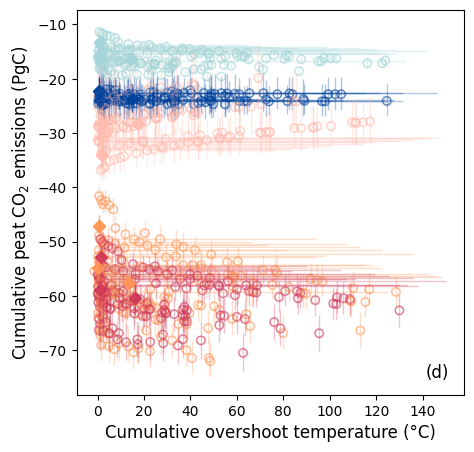

In [68]:
plt.figure(figsize=(5.,5.))
figSI1_plt(ds_calc, 'cum_abs_Ept_CO2','cumT', 'PROVIDE','none') # plot PROVIDE-tier2
figSI1_plt(ds_calc_ssp, 'cum_abs_Ept_CO2','cumT', 'SSP','none') # plot ssp
#plt.legend()
plt.text(0.9, 0.08, "(d)", transform=plt.gca().transAxes, fontsize = 12,  va='top')
plt.xlabel('Cumulative overshoot temperature (\u00B0C)', fontsize = 12)
plt.ylabel('Cumulative peat CO$_2$ emissions (PgC)', fontsize = 12)
plt.savefig(path_fig+'sub_figSI1_Tcum_cumCO2.png', dpi=300, bbox_inches='tight')

## plot 5 - CH4 - Tpeak

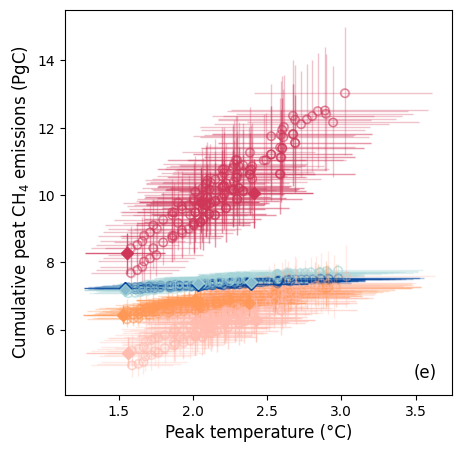

In [69]:
plt.figure(figsize=(5.,5.))
figSI1_plt(ds_calc, 'cum_abs_Ept_CH4','peakT', 'PROVIDE','none') # plot PROVIDE-tier2
figSI1_plt(ds_calc_ssp, 'cum_abs_Ept_CH4','peakT', 'SSP','none') # plot ssp
#plt.legend(fontsize = 8, loc = 'best')
plt.text(0.9, 0.08, "(e)", transform=plt.gca().transAxes, fontsize = 12,  va='top')
plt.xlabel('Peak temperature (\u00B0C)', fontsize = 12)
plt.ylabel('Cumulative peat CH$_4$ emissions (PgC)', fontsize = 12)

plt.savefig(path_fig+'sub_figSI1_Tpeak_cumCH4.png', dpi=300, bbox_inches='tight')

## plot 6 - CH4 - cumT

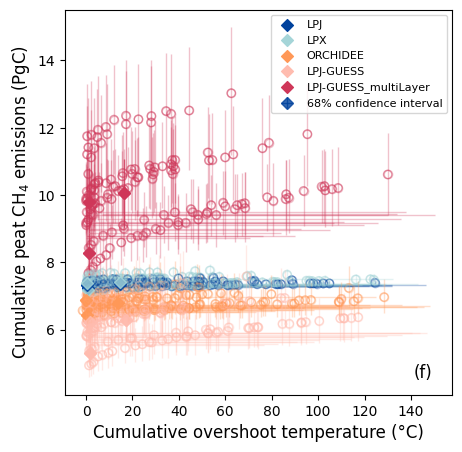

In [70]:
plt.figure(figsize=(5, 5))
figSI1_plt(ds_calc, 'cum_abs_Ept_CH4','cumT', 'PROVIDE','none') # plot PROVIDE-tier2
figSI1_plt(ds_calc_ssp, 'cum_abs_Ept_CH4','cumT', 'SSP','colr') # plot ssp
plt.legend(fontsize = 8, loc = 'best')
plt.text(0.9, 0.08, "(f)", transform=plt.gca().transAxes, fontsize = 12,  va='top')
plt.xlabel('Cumulative overshoot temperature (\u00B0C)', fontsize = 12)
plt.ylabel('Cumulative peat CH$_4$ emissions (PgC)', fontsize = 12)
plt.savefig(path_fig+'sub_figSI1_Tcum_cumCH4.png', dpi=300, bbox_inches='tight')

## combine plots

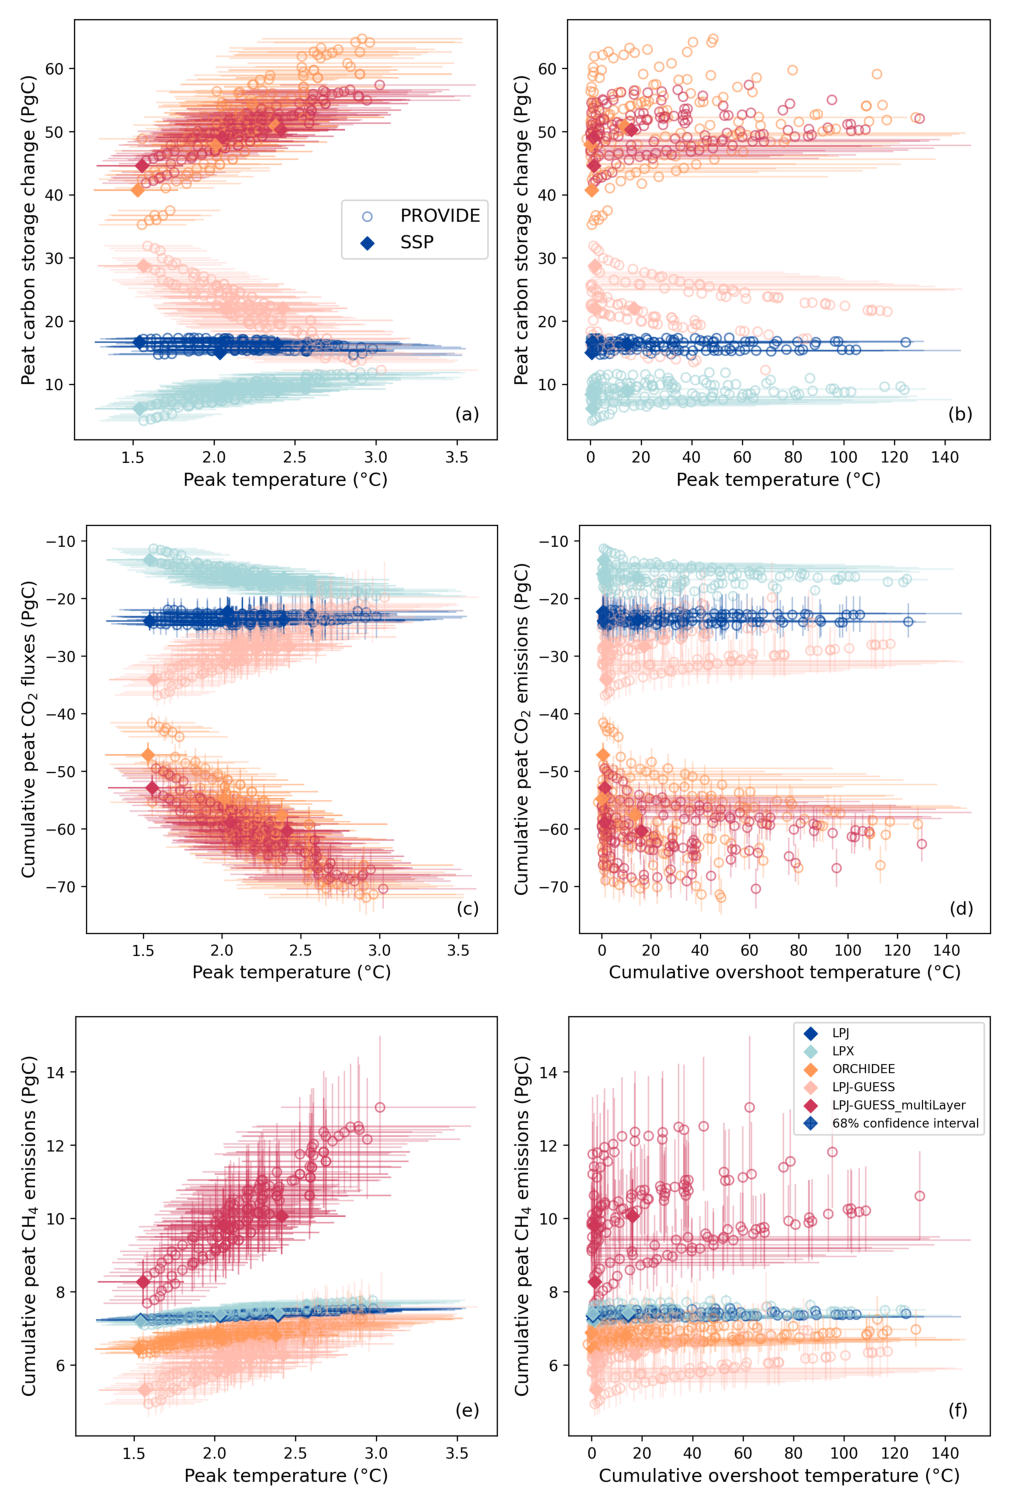

In [72]:
from PIL import Image

# Load the four PNG images
img1 = Image.open(path_fig + 'sub_figSI1_Tpeak_deltaC.png')
img2 = Image.open(path_fig + 'sub_figSI1_cumT_deltaC.png')
img3 = Image.open(path_fig + 'sub_figSI1_Tpeak_cumCO2.png')
img4 = Image.open(path_fig + 'sub_figSI1_Tcum_cumCO2.png')
img5 = Image.open(path_fig + 'sub_figSI1_Tpeak_cumCH4.png')
img6 = Image.open(path_fig + 'sub_figSI1_Tcum_cumCH4.png')

# Set the figure size
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

# Load each image into the corresponding subplot
axes[0, 0].imshow(img1)
axes[0, 1].imshow(img2)
axes[1, 0].imshow(img3)
axes[1, 1].imshow(img4)
axes[2, 0].imshow(img5)
axes[2, 1].imshow(img6)

# Set the axis labels to off for all subplots
for ax in axes.flat:
    ax.set_axis_off()

# Set the spacing between subplots to 0
fig.subplots_adjust( top = 1, bottom = 0,left=0.02, right=1.01, hspace=-0.01, wspace=-0.01)
plt.savefig(path_fig+'figure_SI1.png', dpi=300, bbox_inches='tight')
# also save as pdf
plt.savefig(path_fig+'figure_SI1.pdf', dpi=300, bbox_inches='tight')